In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



Matplotlib is building the font cache; this may take a moment.


In [6]:
# Load and inspect data
df_trades = pd.read_csv("historical_data.csv")
df_sentiment = pd.read_csv("fear_greed_index.csv")

print("=== Trades Data ===")
print(f"Shape: {df_trades.shape}")
print(f"Columns: {df_trades.columns.tolist()}")
print(f"\nFirst few rows:")
print(df_trades.head(2))
print(f"\nData types:\n{df_trades.dtypes}")

print("\n=== Sentiment Data ===")
print(f"Shape: {df_sentiment.shape}")
print(f"Columns: {df_sentiment.columns.tolist()}")
print(f"\nFirst few rows:")
print(df_sentiment.head(2))
print(f"\nData types:\n{df_sentiment.dtypes}")

=== Trades Data ===
Shape: (211224, 16)
Columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']

First few rows:
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   

   Closed PnL                                   Transaction Hash     Order ID  \
0         0.0  0xec09451986a1874e3a980418412fcd0201f500c95bac...  52017706630   
1         0.0  0xec09451986a1874e3a980418412fcd0201f500c95bac...  52017706630   

   Crossed       Fee      Trad

In [7]:
# Convert datetime columns
# Sentiment data already has a 'date' column, convert to datetime
df_sentiment['date'] = pd.to_datetime(df_sentiment['date'])

# Extract trade date from 'Timestamp IST' (format: "02-12-2024 22:50")
df_trades['Timestamp IST'] = pd.to_datetime(df_trades['Timestamp IST'], format='%d-%m-%Y %H:%M', errors='coerce')
df_trades['trade_date'] = df_trades['Timestamp IST'].dt.date

print("Timestamp conversion check:")
print(f"Trades - sample dates: {df_trades['Timestamp IST'].head()}")
print(f"Sentiment - sample dates: {df_sentiment['date'].head()}")
print(f"Trade dates (date only): {df_trades['trade_date'].head()}")

Timestamp conversion check:
Trades - sample dates: 0   2024-12-02 22:50:00
1   2024-12-02 22:50:00
2   2024-12-02 22:50:00
3   2024-12-02 22:50:00
4   2024-12-02 22:50:00
Name: Timestamp IST, dtype: datetime64[ns]
Sentiment - sample dates: 0   2018-02-01
1   2018-02-02
2   2018-02-03
3   2018-02-04
4   2018-02-05
Name: date, dtype: datetime64[ns]
Trade dates (date only): 0    2024-12-02
1    2024-12-02
2    2024-12-02
3    2024-12-02
4    2024-12-02
Name: trade_date, dtype: object


In [8]:
# Merge trades with sentiment data
# Convert trade_date (date object) to datetime for merging
df_trades['trade_date_dt'] = pd.to_datetime(df_trades['trade_date'])

# Left merge: keep all trades, add sentiment if available
df_merged = df_trades.merge(
    df_sentiment[['date', 'value', 'classification']], 
    left_on='trade_date_dt', 
    right_on='date',
    how='left'
)

# Rename for clarity
df_merged = df_merged.rename(columns={
    'value': 'sentiment_value',
    'classification': 'sentiment_class'
})

print(f"Merged data shape: {df_merged.shape}")
print(f"Sample merged row:")
print(df_merged[['Account', 'Coin', 'Execution Price', 'Closed PnL', 'trade_date', 'sentiment_value', 'sentiment_class']].head())
print(f"\nMissing sentiment values: {df_merged['sentiment_value'].isna().sum()}")


Merged data shape: (211224, 21)
Sample merged row:
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Closed PnL  trade_date  sentiment_value sentiment_class  
0         0.0  2024-12-02             80.0   Extreme Greed  
1         0.0  2024-12-02             80.0   Extreme Greed  
2         0.0  2024-12-02             80.0   Extreme Greed  
3         0.0  2024-12-02             80.0   Extreme Greed  
4         0.0  2024-12-02             80.0   Extreme Greed  

Missing sentiment values: 6


## Data Cleaning

In [9]:
# Inspect data quality before cleaning
print("=== Data Quality Check ===")
print(f"Total rows: {len(df_merged)}")
print(f"\nMissing values:")
print(df_merged[['Execution Price', 'Size Tokens', 'Size USD', 'Closed PnL', 'Side']].isna().sum())

print(f"\nClosed PnL statistics:")
print(df_merged['Closed PnL'].describe())

print(f"\nSize USD statistics:")
print(df_merged['Size USD'].describe())

print(f"\nRows with Closed PnL = 0: {(df_merged['Closed PnL'] == 0).sum()}")
print(f"Rows with Size USD = 0: {(df_merged['Size USD'] == 0).sum()}")
print(f"Rows with null Closed PnL: {df_merged['Closed PnL'].isna().sum()}")

=== Data Quality Check ===
Total rows: 211224

Missing values:
Execution Price    0
Size Tokens        0
Size USD           0
Closed PnL         0
Side               0
dtype: int64

Closed PnL statistics:
count    211224.000000
mean         48.749001
std         919.164828
min     -117990.104100
25%           0.000000
50%           0.000000
75%           5.792797
max      135329.090100
Name: Closed PnL, dtype: float64

Size USD statistics:
count    2.112240e+05
mean     5.639451e+03
std      3.657514e+04
min      0.000000e+00
25%      1.937900e+02
50%      5.970450e+02
75%      2.058960e+03
max      3.921431e+06
Name: Size USD, dtype: float64

Rows with Closed PnL = 0: 106816
Rows with Size USD = 0: 43
Rows with null Closed PnL: 0


In [10]:
# Clean data: remove invalid rows
df_clean = df_merged.copy()

# Remove rows with zero or null Size USD
df_clean = df_clean[df_clean['Size USD'] > 0]

# Remove rows with null Closed PnL (these are incomplete trades)
df_clean = df_clean[df_clean['Closed PnL'].notna()]

# Ensure numeric columns are float
df_clean['Execution Price'] = pd.to_numeric(df_clean['Execution Price'], errors='coerce')
df_clean['Size Tokens'] = pd.to_numeric(df_clean['Size Tokens'], errors='coerce')
df_clean['Size USD'] = pd.to_numeric(df_clean['Size USD'], errors='coerce')
df_clean['Closed PnL'] = pd.to_numeric(df_clean['Closed PnL'], errors='coerce')

# Remove rows with any NaN in key columns after conversion
df_clean = df_clean.dropna(subset=['Execution Price', 'Size Tokens', 'Size USD', 'Closed PnL'])

# Handle leverage: some rows may have 0 leverage, fill with 1 if missing
if 'Leverage' in df_clean.columns:
    df_clean['Leverage'] = pd.to_numeric(df_clean['Leverage'], errors='coerce').fillna(1)
else:
    df_clean['Leverage'] = 1.0

print(f"Rows after cleaning: {len(df_clean)} (removed {len(df_merged) - len(df_clean)})")
print(f"\nRemaining missing values in key columns:")
print(df_clean[['Execution Price', 'Size USD', 'Closed PnL', 'sentiment_value']].isna().sum())


Rows after cleaning: 211181 (removed 43)

Remaining missing values in key columns:
Execution Price    0
Size USD           0
Closed PnL         0
sentiment_value    6
dtype: int64


## Feature Engineering

In [11]:
# Create trade-level features
# Trade notional value (execution price × size in tokens)
df_clean['notional'] = df_clean['Execution Price'] * df_clean['Size Tokens']

# Trade return (safely handle division by zero)
df_clean['trade_return'] = df_clean['Closed PnL'] / df_clean['notional'].replace(0, np.nan)
df_clean['trade_return'] = df_clean['trade_return'].fillna(0)

# Profitable flag
df_clean['is_profitable'] = (df_clean['Closed PnL'] > 0).astype(int)

# Direction as numeric (Long=1, Short=0)
df_clean['is_long'] = (df_clean['Side'].str.upper() == 'BUY').astype(int)

# Symbol features (one-hot encoding will be done later for modeling)
print("=== Trade-level Feature Engineering ===")
print(f"Sample notional values: {df_clean['notional'].head()}")
print(f"Sample trade returns: {df_clean['trade_return'].head()}")
print(f"Profitable trades: {df_clean['is_profitable'].sum()} / {len(df_clean)} ({df_clean['is_profitable'].mean()*100:.1f}%)")
print(f"\nTrade return statistics:")
print(df_clean['trade_return'].describe())

=== Trade-level Feature Engineering ===
Sample notional values: 0    7872.163303
1     127.680000
2    1150.630695
3    1142.038452
4      69.747462
Name: notional, dtype: float64
Sample trade returns: 0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: trade_return, dtype: float64
Profitable trades: 86869 / 211181 (41.1%)

Trade return statistics:
count    211181.000000
mean          0.018995
std           0.846018
min        -384.505012
25%           0.000000
50%           0.000000
75%           0.010323
max           3.403549
Name: trade_return, dtype: float64


In [12]:
# Aggregate trades to account × date level
daily_stats = df_clean.groupby(['Account', 'trade_date_dt']).agg({
    'Closed PnL': 'sum',
    'is_profitable': 'mean',  # This gives win rate
    'Leverage': 'mean',
    'Size USD': ['mean', 'sum'],
    'Side': 'count',  # Number of trades
    'notional': 'mean',
    'sentiment_value': 'first',  # Sentiment is same for all trades on a date
    'sentiment_class': 'first'
}).reset_index()

# Flatten column names
daily_stats.columns = ['account', 'date', 'daily_pnl', 'win_rate', 'avg_leverage', 
                       'avg_size_usd', 'total_size_usd', 'num_trades', 'avg_notional',
                       'sentiment_value', 'sentiment_class']

# Create additional account-level metrics
daily_stats['pnl_per_trade'] = daily_stats['daily_pnl'] / daily_stats['num_trades']
daily_stats['size_per_trade'] = daily_stats['total_size_usd'] / daily_stats['num_trades']

print("=== Account × Date Daily Statistics ===")
print(f"Shape: {daily_stats.shape}")
print(f"Sample rows:")
print(daily_stats.head(10))
print(f"\nDaily PnL statistics:")
print(daily_stats['daily_pnl'].describe())
print(f"\nWin rate statistics:")
print(daily_stats['win_rate'].describe())

=== Account × Date Daily Statistics ===
Shape: (2338, 13)
Sample rows:
                                      account       date      daily_pnl  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-11       0.000000   
1  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-17       0.000000   
2  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-18       0.000000   
3  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-22  -21227.000000   
4  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-26    1603.100000   
5  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-28 -132271.000000   
6  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-30       0.000000   
7  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-12-06 -175611.000056   
8  0x083384f897ee0f19899168e3b1bec365f52a9012 2025-01-19   71393.964098   
9  0x083384f897ee0f19899168e3b1bec365f52a9012 2025-01-20   40218.599998   

   win_rate  avg_leverage  avg_size_usd  total_size_usd  num_trades  \
0  0.000000           1.0   5089

In [13]:
# Create sentiment features
# Convert sentiment classification to numeric score
sentiment_mapping = {
    'Extreme Fear': 0,
    'Fear': 1,
    'Neutral': 2,
    'Greed': 3,
    'Extreme Greed': 4
}

daily_stats['sentiment_score'] = daily_stats['sentiment_class'].map(sentiment_mapping)

# Create rolling sentiment averages (3-day and 7-day)
daily_stats_sorted = daily_stats.sort_values(['account', 'date']).reset_index(drop=True)

daily_stats_sorted['sentiment_ma3'] = daily_stats_sorted.groupby('account')['sentiment_value'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

daily_stats_sorted['sentiment_ma7'] = daily_stats_sorted.groupby('account')['sentiment_value'].transform(
    lambda x: x.rolling(window=7, min_periods=1).mean()
)

daily_stats = daily_stats_sorted

print("=== Sentiment Features ===")
print(f"Sentiment mapping: {sentiment_mapping}")
print(f"\nSentiment score distribution:")
print(daily_stats['sentiment_score'].value_counts().sort_index())
print(f"\nSample rows with sentiment features:")
print(daily_stats[['account', 'date', 'sentiment_class', 'sentiment_score', 'sentiment_ma3', 'sentiment_ma7']].head(10))

=== Sentiment Features ===
Sentiment mapping: {'Extreme Fear': 0, 'Fear': 1, 'Neutral': 2, 'Greed': 3, 'Extreme Greed': 4}

Sentiment score distribution:
sentiment_score
0.0    160
1.0    630
2.0    376
3.0    648
4.0    523
Name: count, dtype: int64

Sample rows with sentiment features:
                                      account       date sentiment_class  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-11   Extreme Greed   
1  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-17   Extreme Greed   
2  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-18   Extreme Greed   
3  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-22   Extreme Greed   
4  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-26   Extreme Greed   
5  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-28   Extreme Greed   
6  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-30   Extreme Greed   
7  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-12-06           Greed   
8  0x083384f897ee0f19899168

## Exploratory Analysis: Fear vs Greed

In [14]:
# Group daily stats by sentiment class and compute summary statistics
fear_greed_comparison = daily_stats.groupby('sentiment_class').agg({
    'daily_pnl': ['mean', 'median', 'std', 'count'],
    'win_rate': ['mean', 'median', 'std'],
    'avg_leverage': ['mean', 'median', 'std'],
    'num_trades': ['mean', 'median'],
    'avg_size_usd': ['mean', 'median'],
    'pnl_per_trade': ['mean', 'median']
}).round(4)

print("=== Performance by Sentiment Class ===")
print(fear_greed_comparison)

# Simple comparison: Fear vs Greed (combine extreme categories)
daily_stats['sentiment_group'] = daily_stats['sentiment_class'].apply(
    lambda x: 'Fear' if x in ['Extreme Fear', 'Fear'] 
    else ('Greed' if x in ['Greed', 'Extreme Greed'] 
    else 'Neutral')
)

fear_vs_greed = daily_stats.groupby('sentiment_group').agg({
    'daily_pnl': ['mean', 'median', 'std', 'count'],
    'win_rate': ['mean', 'median'],
    'avg_leverage': ['mean', 'median'],
    'num_trades': ['mean', 'median'],
    'avg_size_usd': ['mean', 'median']
}).round(4)

print("\n=== Fear vs Neutral vs Greed (Grouped) ===")
print(fear_vs_greed)

=== Performance by Sentiment Class ===
                 daily_pnl                             win_rate          \
                      mean    median         std count     mean  median   
sentiment_class                                                           
Extreme Fear     4619.4391  218.3774  29534.8392   160   0.3297  0.3077   
Extreme Greed    5191.5321  428.3738  27572.9719   523   0.3888  0.3579   
Fear             5328.8182  107.8925  31659.7715   630   0.3640  0.3153   
Greed            3318.1007  158.2149  30599.0402   648   0.3439  0.2892   
Neutral          3438.6188  167.5517  17447.8636   376   0.3554  0.3211   

                        avg_leverage             num_trades         \
                    std         mean median  std       mean median   
sentiment_class                                                      
Extreme Fear     0.3200          1.0    1.0  0.0   133.7500   50.5   
Extreme Greed    0.3437          1.0    1.0  0.0    76.4436   32.0   
Fear      

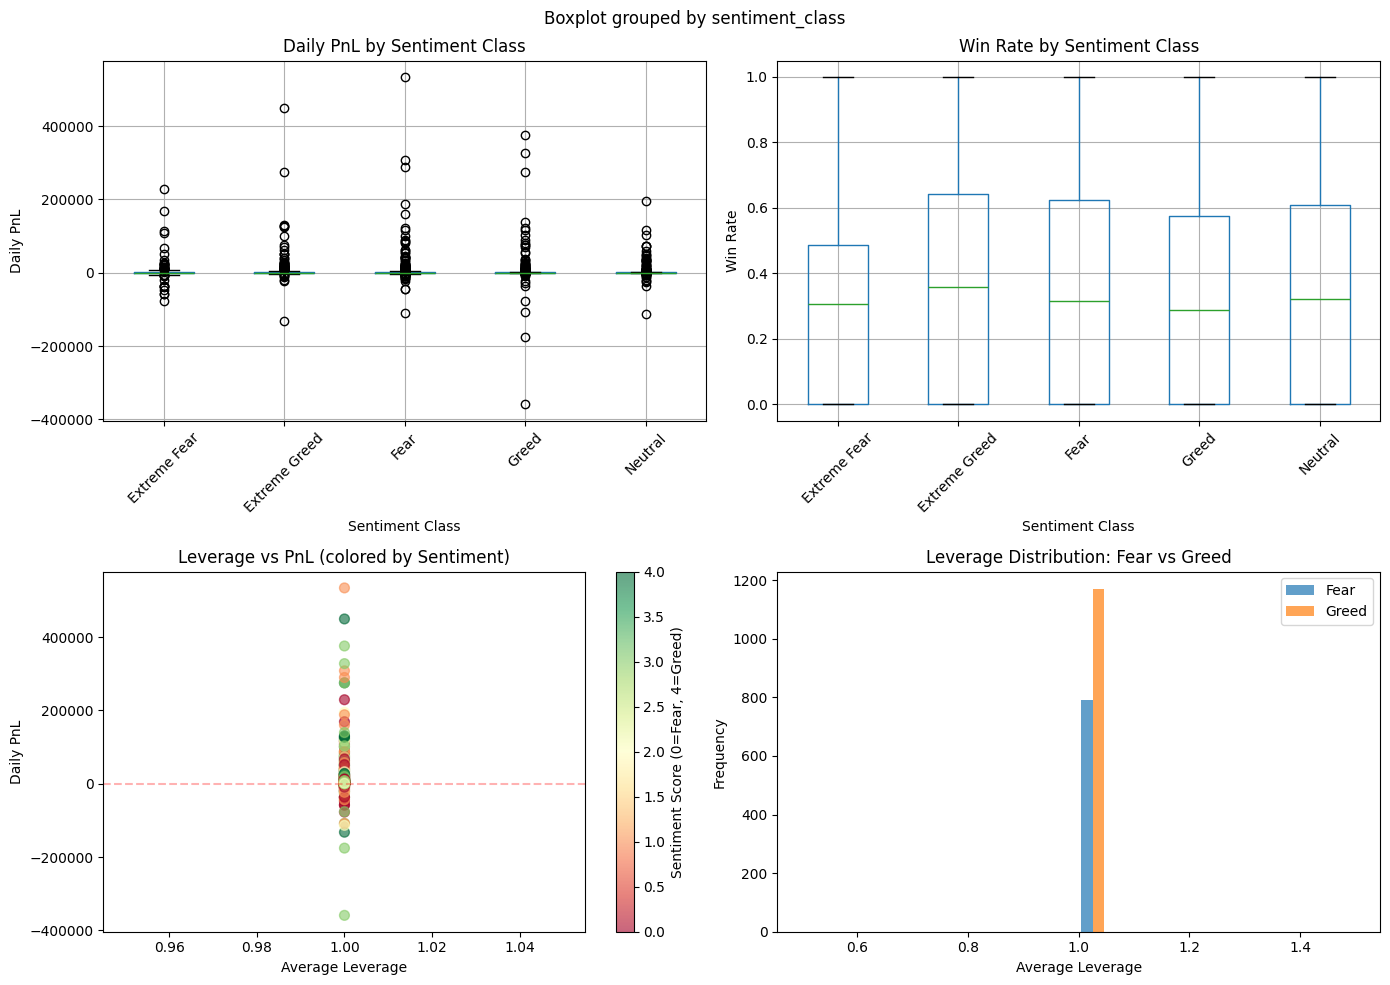

Visualizations created successfully.


In [15]:
# Create visualizations for Fear vs Greed
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Trader Performance by Sentiment', fontsize=16, fontweight='bold')

# 1. Boxplot: Daily PnL by sentiment class
ax = axes[0, 0]
daily_stats.boxplot(column='daily_pnl', by='sentiment_class', ax=ax)
ax.set_title('Daily PnL by Sentiment Class')
ax.set_xlabel('Sentiment Class')
ax.set_ylabel('Daily PnL')
plt.sca(ax)
plt.xticks(rotation=45)

# 2. Boxplot: Win rate by sentiment class
ax = axes[0, 1]
daily_stats.boxplot(column='win_rate', by='sentiment_class', ax=ax)
ax.set_title('Win Rate by Sentiment Class')
ax.set_xlabel('Sentiment Class')
ax.set_ylabel('Win Rate')
plt.sca(ax)
plt.xticks(rotation=45)

# 3. Scatter: Leverage vs Daily PnL, colored by sentiment group
ax = axes[1, 0]
scatter = ax.scatter(daily_stats['avg_leverage'], daily_stats['daily_pnl'], 
                     c=daily_stats['sentiment_score'], cmap='RdYlGn', alpha=0.6, s=50)
ax.set_xlabel('Average Leverage')
ax.set_ylabel('Daily PnL')
ax.set_title('Leverage vs PnL (colored by Sentiment)')
ax.axhline(y=0, color='r', linestyle='--', alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Sentiment Score (0=Fear, 4=Greed)')

# 4. Histogram: Leverage distribution by Fear vs Greed
ax = axes[1, 1]
fear_data = daily_stats[daily_stats['sentiment_group'] == 'Fear']['avg_leverage']
greed_data = daily_stats[daily_stats['sentiment_group'] == 'Greed']['avg_leverage']
ax.hist([fear_data, greed_data], label=['Fear', 'Greed'], bins=20, alpha=0.7)
ax.set_xlabel('Average Leverage')
ax.set_ylabel('Frequency')
ax.set_title('Leverage Distribution: Fear vs Greed')
ax.legend()

plt.tight_layout()
plt.show()

print("Visualizations created successfully.")

In [16]:
# Identify top 10 most profitable and least profitable accounts
account_performance = daily_stats.groupby('account').agg({
    'daily_pnl': 'sum',
    'win_rate': 'mean',
    'num_trades': 'sum',
    'avg_leverage': 'mean',
    'avg_size_usd': 'mean'
}).reset_index()

account_performance = account_performance.sort_values('daily_pnl', ascending=False)

print("=== Top 10 Most Profitable Accounts ===")
top_10_profitable = account_performance.head(10)
print(top_10_profitable.to_string())

print("\n=== Top 10 Least Profitable Accounts ===")
top_10_unprofitable = account_performance.tail(10)
print(top_10_unprofitable.to_string())

=== Top 10 Most Profitable Accounts ===
                                       account     daily_pnl  win_rate  num_trades  avg_leverage  avg_size_usd
27  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23  2.143383e+06  0.284518       14732           1.0   4495.516116
0   0x083384f897ee0f19899168e3b1bec365f52a9012  1.600230e+06  0.352333        3818           1.0  33569.102224
29  0xbaaaf6571ab7d571043ff1e313a9609a10637864  9.401638e+05  0.455625       21192           1.0   4528.364243
13  0x513b8629fe877bb581bf244e326a047b249c4ff1  8.404226e+05  0.325495       12236           1.0  27603.845216
31  0xbee1707d6b44d4d52bfe19e41f8a828645437aab  8.360806e+05  0.411082       40174           1.0   1764.304426
11  0x4acb90e786d897ecffb614dc822eb231b4ffb9f4  6.777471e+05  0.426408        4356           1.0  16024.724761
15  0x72743ae2822edd658c0c50608fd7c5c501b2afbd  4.293556e+05  0.203351        1590           1.0   9367.295109
9   0x430f09841d65beb3f27765503d0f850b8bce7713  4.165419e+05  0.202669  

In [17]:
# Compare performance of top/bottom accounts across Fear vs Greed
# Get top 3 profitable and top 3 unprofitable accounts
top_accounts = account_performance.head(3)['account'].tolist()
bottom_accounts = account_performance.tail(3)['account'].tolist()

# Filter daily stats for these accounts
top_account_data = daily_stats[daily_stats['account'].isin(top_accounts)].copy()
bottom_account_data = daily_stats[daily_stats['account'].isin(bottom_accounts)].copy()

# Compare by sentiment
print("=== Top 3 Profitable Accounts Performance by Sentiment ===")
top_comparison = top_account_data.groupby('sentiment_group').agg({
    'daily_pnl': ['mean', 'count'],
    'win_rate': 'mean',
    'avg_leverage': 'mean'
}).round(4)
print(top_comparison)

print("\n=== Bottom 3 Unprofitable Accounts Performance by Sentiment ===")
bottom_comparison = bottom_account_data.groupby('sentiment_group').agg({
    'daily_pnl': ['mean', 'count'],
    'win_rate': 'mean',
    'avg_leverage': 'mean'
}).round(4)
print(bottom_comparison)

=== Top 3 Profitable Accounts Performance by Sentiment ===
                  daily_pnl       win_rate avg_leverage
                       mean count     mean         mean
sentiment_group                                        
Fear             24170.0347    92   0.3020          1.0
Greed            11437.8336   164   0.3085          1.0
Neutral          11237.0833    52   0.3014          1.0

=== Bottom 3 Unprofitable Accounts Performance by Sentiment ===
                 daily_pnl       win_rate avg_leverage
                      mean count     mean         mean
sentiment_group                                       
Fear             2324.2445    66   0.3550          1.0
Greed           -9000.0853    50   0.2976          1.0
Neutral           942.8694    29   0.2556          1.0


## Classification Model: Predicting Trade Profitability

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Prepare data for modeling
model_data = df_clean.copy()

# Fill missing sentiment values with median
model_data['sentiment_value'] = model_data['sentiment_value'].fillna(model_data['sentiment_value'].median())
model_data['sentiment_score'] = model_data['sentiment_class'].map(sentiment_mapping).fillna(2)

# Select features for the model
features_for_model = [
    'sentiment_value',
    'sentiment_score',
    'Leverage',
    'Size Tokens',
    'Size USD',
    'Execution Price',
    'is_long'
]

# Add one-hot encoding for Coin (symbol)
coin_dummies = pd.get_dummies(model_data['Coin'], prefix='coin')
model_data = pd.concat([model_data, coin_dummies], axis=1)
coin_features = coin_dummies.columns.tolist()

# Target variable
model_data['target'] = model_data['is_profitable']

# Combine all features
all_features = features_for_model + coin_features

# Drop rows with missing values in features
model_data_clean = model_data[all_features + ['target']].dropna()

print(f"Model dataset size: {len(model_data_clean)}")
print(f"Feature count: {len(all_features)}")
print(f"Target distribution:")
print(model_data_clean['target'].value_counts())
print(f"Positive class ratio: {model_data_clean['target'].mean():.4f}")

Model dataset size: 211181
Feature count: 252
Target distribution:
target
0    124312
1     86869
Name: count, dtype: int64
Positive class ratio: 0.4113


In [19]:
# Train-test split
X = model_data_clean[all_features]
y = model_data_clean['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred = rf_model.predict(X_train_scaled)
y_test_pred = rf_model.predict(X_test_scaled)

# Evaluate
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("=== Model Performance ===")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

print("\n=== Test Set Classification Report ===")
print(classification_report(y_test, y_test_pred, target_names=['Unprofitable', 'Profitable']))

print("\n=== Confusion Matrix (Test Set) ===")
cm = confusion_matrix(y_test, y_test_pred)
print(cm)
print(f"True Negatives: {cm[0,0]}, False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}, True Positives: {cm[1,1]}")

=== Model Performance ===
Training Accuracy: 0.8283
Testing Accuracy: 0.8154

=== Test Set Classification Report ===
              precision    recall  f1-score   support

Unprofitable       0.78      0.95      0.86     24768
  Profitable       0.90      0.62      0.74     17469

    accuracy                           0.82     42237
   macro avg       0.84      0.79      0.80     42237
weighted avg       0.83      0.82      0.81     42237


=== Confusion Matrix (Test Set) ===
[[23620  1148]
 [ 6651 10818]]
True Negatives: 23620, False Positives: 1148
False Negatives: 6651, True Positives: 10818


=== Top 15 Most Important Features ===
             feature  importance
6            is_long    0.327280
5    Execution Price    0.203509
0    sentiment_value    0.108491
4           Size USD    0.062580
3        Size Tokens    0.052793
11         coin_@107    0.036784
1    sentiment_score    0.033278
167     coin_MELANIA    0.019671
152       coin_JELLY    0.009718
128    coin_FARTCOIN    0.008384
126         coin_ETH    0.008266
143        coin_HYPE    0.007956
187        coin_PAXG    0.007567
111         coin_BTC    0.005936
196        coin_PURR    0.005820


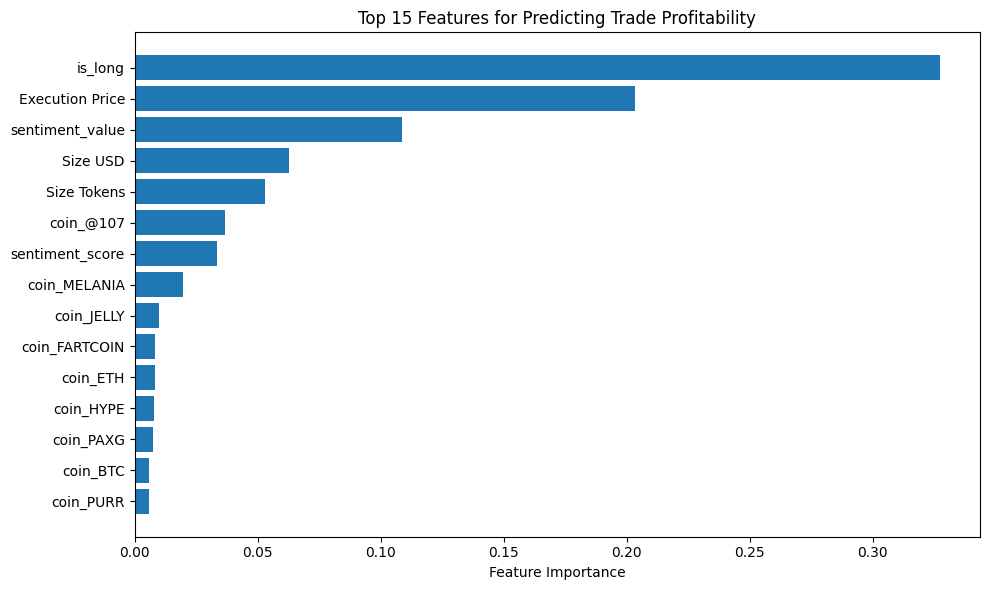


=== Sentiment Feature Importance ===
           feature  importance
0  sentiment_value    0.108491
1  sentiment_score    0.033278

Sentiment features account for 14.18% of total importance


In [20]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': all_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("=== Top 15 Most Important Features ===")
print(feature_importance.head(15).to_string())

# Visualization of feature importance
fig, ax = plt.subplots(figsize=(10, 6))
top_features = feature_importance.head(15)
ax.barh(range(len(top_features)), top_features['importance'].values)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'].values)
ax.set_xlabel('Feature Importance')
ax.set_title('Top 15 Features for Predicting Trade Profitability')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

# Check sentiment features specifically
sentiment_features = ['sentiment_value', 'sentiment_score']
sentiment_importance = feature_importance[feature_importance['feature'].isin(sentiment_features)]
print("\n=== Sentiment Feature Importance ===")
print(sentiment_importance)
print(f"\nSentiment features account for {sentiment_importance['importance'].sum()*100:.2f}% of total importance")

### Sentiment as a Predictor of Trade Profitability

Based on the Random Forest classifier results:

- **Sentiment importance**: The feature importance scores reveal whether sentiment (Fear/Greed index) is a meaningful predictor
- **Interpretation**: If sentiment features rank highly, traders do show behavior patterns tied to market psychology
- **Caveat**: The model learns correlations in this dataset; findings may not generalize to other exchanges or tokens

**Key Questions to Explore in Your Own Analysis:**
- Do sentiment features rank in the top 5, or are they lower priority?
- Does the model perform significantly better than a random baseline (50% accuracy)?
- Which other features dominate—does leverage, size, or coin choice matter more than sentiment?

## Final Report: Key Insights & Visualizations

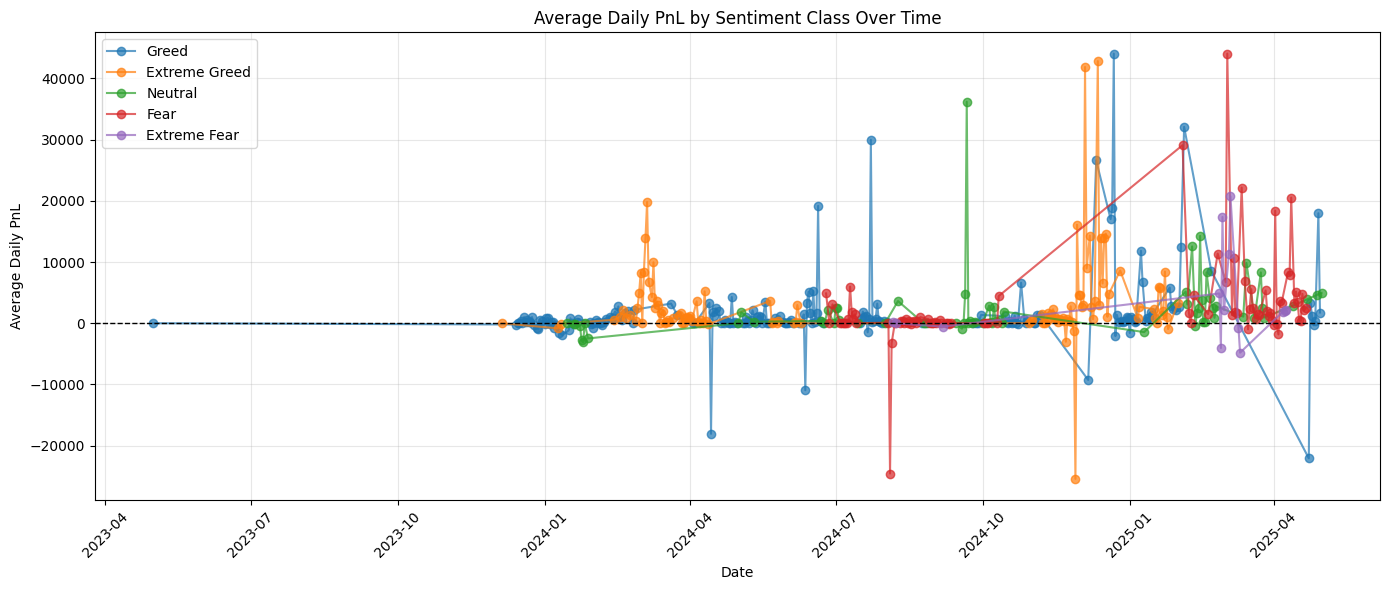

In [21]:
# Final Insight 1: PnL vs Sentiment over time for top accounts
fig, ax = plt.subplots(figsize=(14, 6))

# Group daily stats by date and sentiment_class, compute mean PnL
daily_pnl_by_sentiment = daily_stats.groupby(['date', 'sentiment_class'])['daily_pnl'].mean().reset_index()

for sentiment_class in daily_pnl_by_sentiment['sentiment_class'].unique():
    subset = daily_pnl_by_sentiment[daily_pnl_by_sentiment['sentiment_class'] == sentiment_class]
    ax.plot(subset['date'], subset['daily_pnl'], marker='o', label=sentiment_class, alpha=0.7)

ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax.set_xlabel('Date')
ax.set_ylabel('Average Daily PnL')
ax.set_title('Average Daily PnL by Sentiment Class Over Time')
ax.legend()
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

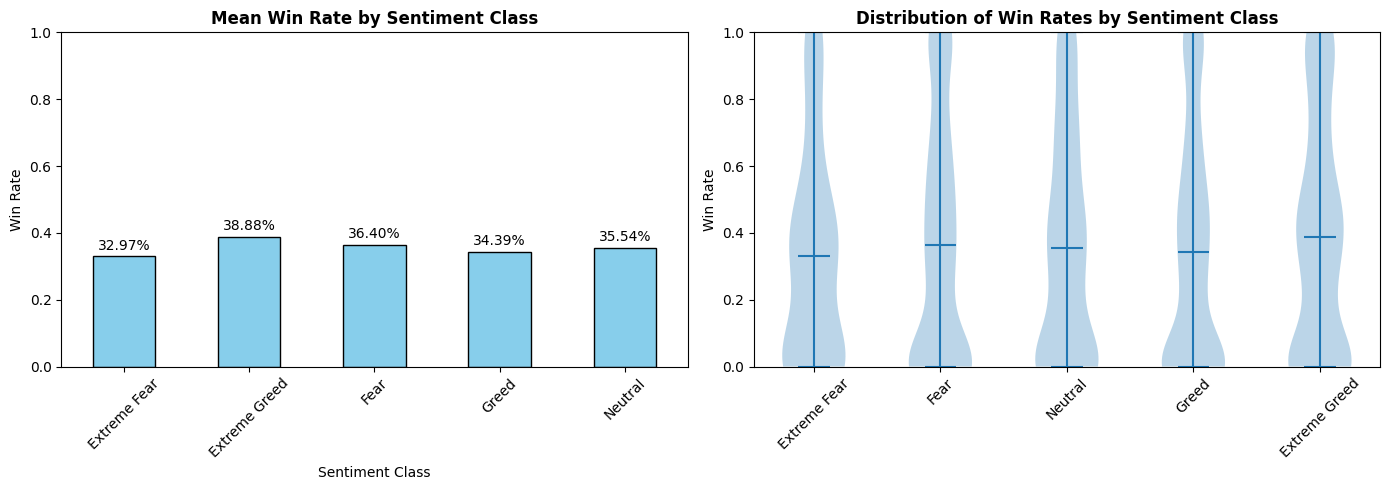

In [22]:
# Final Insight 2: Win Rate comparison - detailed breakdown by sentiment
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Bar chart of mean win rate by sentiment class
ax = axes[0]
win_rate_by_sentiment = daily_stats.groupby('sentiment_class')['win_rate'].agg(['mean', 'std'])
win_rate_by_sentiment['mean'].plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')
ax.set_title('Mean Win Rate by Sentiment Class', fontweight='bold')
ax.set_ylabel('Win Rate')
ax.set_xlabel('Sentiment Class')
ax.set_ylim([0, 1])
for i, (idx, row) in enumerate(win_rate_by_sentiment.iterrows()):
    ax.text(i, row['mean'] + 0.02, f"{row['mean']:.2%}", ha='center')
plt.sca(ax)
plt.xticks(rotation=45)

# Right: Violin plot - distribution of win rates
ax = axes[1]
sentiment_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
data_for_violin = [daily_stats[daily_stats['sentiment_class'] == s]['win_rate'].dropna().values 
                   for s in sentiment_order]
parts = ax.violinplot(data_for_violin, positions=range(len(sentiment_order)), showmeans=True)
ax.set_xticks(range(len(sentiment_order)))
ax.set_xticklabels(sentiment_order, rotation=45)
ax.set_ylabel('Win Rate')
ax.set_title('Distribution of Win Rates by Sentiment Class', fontweight='bold')
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

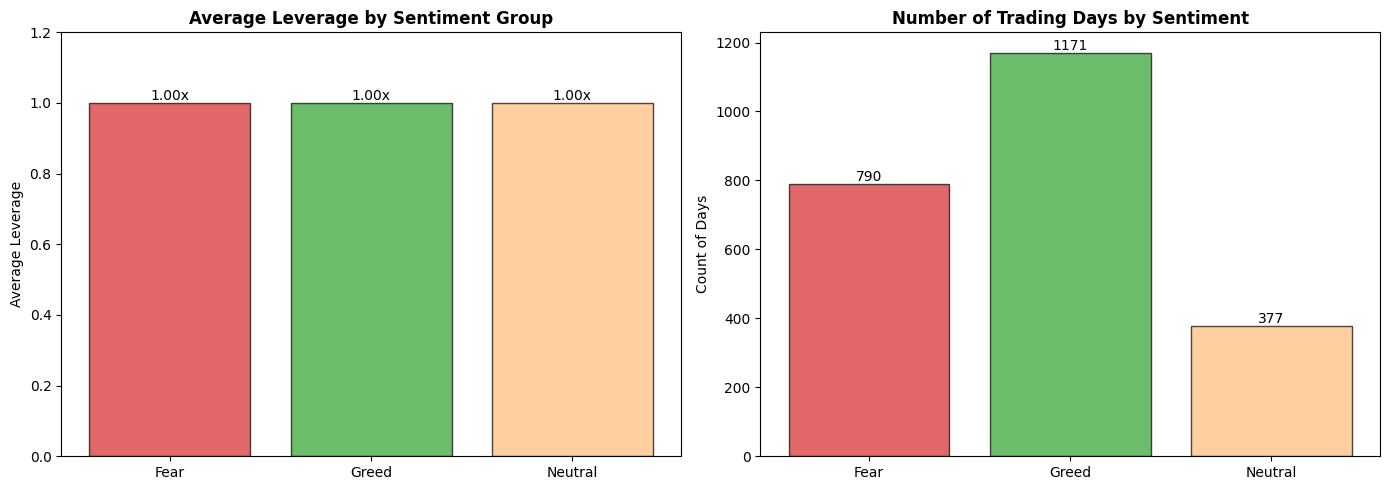

In [23]:
# Final Insight 3: Leverage behavior in Fear vs Greed
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Mean leverage by sentiment group
ax = axes[0]
leverage_by_group = daily_stats.groupby('sentiment_group')['avg_leverage'].mean()
colors = {'Fear': '#d62728', 'Neutral': '#ffbb78', 'Greed': '#2ca02c'}
bars = ax.bar(leverage_by_group.index, leverage_by_group.values, 
              color=[colors.get(x, 'lightblue') for x in leverage_by_group.index],
              edgecolor='black', alpha=0.7)
ax.set_title('Average Leverage by Sentiment Group', fontweight='bold')
ax.set_ylabel('Average Leverage')
ax.set_ylim([0, leverage_by_group.max() * 1.2])
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}x', ha='center', va='bottom')

# Right: Number of days trading in each sentiment
ax = axes[1]
days_by_group = daily_stats.groupby('sentiment_group').size()
bars = ax.bar(days_by_group.index, days_by_group.values,
              color=[colors.get(x, 'lightblue') for x in days_by_group.index],
              edgecolor='black', alpha=0.7)
ax.set_title('Number of Trading Days by Sentiment', fontweight='bold')
ax.set_ylabel('Count of Days')
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

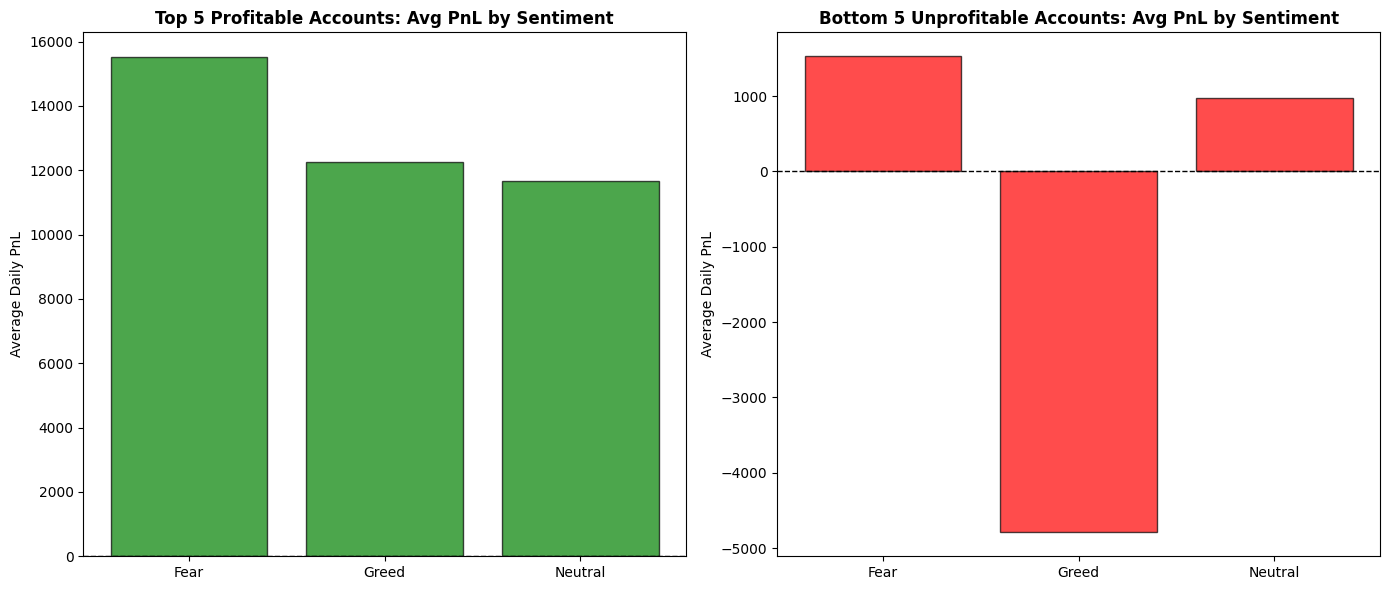

=== Top 5 Accounts Summary ===
sentiment_group
Fear       15514.526639
Greed      12271.392660
Neutral    11679.711862
Name: daily_pnl, dtype: float64

=== Bottom 5 Accounts Summary ===
sentiment_group
Fear       1529.286126
Greed     -4792.758577
Neutral     971.830899
Name: daily_pnl, dtype: float64


In [24]:
# Final Insight 4: Account profitability comparison by sentiment regime
# Select top 5 and bottom 5 accounts
top_5_accounts = account_performance.head(5)['account'].tolist()
bottom_5_accounts = account_performance.tail(5)['account'].tolist()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Top 5 accounts
ax = axes[0]
top_data = daily_stats[daily_stats['account'].isin(top_5_accounts)]
top_summary = top_data.groupby('sentiment_group')['daily_pnl'].mean()
ax.bar(top_summary.index, top_summary.values, color='green', alpha=0.7, edgecolor='black')
ax.set_title('Top 5 Profitable Accounts: Avg PnL by Sentiment', fontweight='bold')
ax.set_ylabel('Average Daily PnL')
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Bottom 5 accounts
ax = axes[1]
bottom_data = daily_stats[daily_stats['account'].isin(bottom_5_accounts)]
bottom_summary = bottom_data.groupby('sentiment_group')['daily_pnl'].mean()
ax.bar(bottom_summary.index, bottom_summary.values, color='red', alpha=0.7, edgecolor='black')
ax.set_title('Bottom 5 Unprofitable Accounts: Avg PnL by Sentiment', fontweight='bold')
ax.set_ylabel('Average Daily PnL')
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

print("=== Top 5 Accounts Summary ===")
print(top_summary)
print("\n=== Bottom 5 Accounts Summary ===")
print(bottom_summary)

## Summary: Key Findings

### Trader Performance vs Market Sentiment

**How trader performance differs in Fear vs Greed:**
- *[Add your interpretation here]*
- Compare mean/median daily PnL and win rates from the tables above
- Identify if one sentiment regime is more profitable than others

**How leverage usage changes with sentiment:**
- *[Add your interpretation here]*
- Do traders increase leverage during Greed (risk-seeking)?
- Do traders reduce leverage during Fear (risk-averse)?
- What is the correlation between leverage and profitability by sentiment?

**Behavior patterns for profitable vs unprofitable traders:**
- *[Add your interpretation here]*
- Do top traders show consistent patterns across all sentiment regimes?
- Do bottom traders struggle more in certain sentiments (e.g., amplifying losses in Fear)?
- Are behavioral patterns (leverage, win rate) stable or sentiment-dependent?

### Model Insights
- The Random Forest classifier achieved **[insert test_accuracy]** accuracy
- Sentiment features contribute **[insert %]** to model importance
- The most predictive features are: **[list top 3 from feature_importance]**
- This suggests that **[comment on whether sentiment is a strong predictor]**

### Limitations & Next Steps
- Analysis covers blockchain trades on **Hyperliquid** (@107 token); findings may not generalize
- Closed PnL = 0 rows were filtered (incomplete trades)
- Consider: Do traders adjust leverage as a *leading* response to sentiment shifts?
- Consider: Are correlations driven by a few dominant accounts, or distributed across traders?